# **Course project on Technologies and Infrastructure for Big Data**
part I : image collecting from flickr


Project topic: spam message with data collection from www.flickr.com database

Project executors:

Ma Cheng Yuan , ISU 372818 , J4133c

In [2]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=f8c693670c431f67b56513b4ac0b785e8a214ae66936600a14b21eed6e67de7b
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [3]:
pip install flickrapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.3 MB/s eta 0:00:00


In [4]:
pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.5 MB/s eta 0:00:00


In [5]:
import pyspark.pandas as ps
import flickrapi
from flickrapi import FlickrAPI
import os
import warnings

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


#Download image from flick with flickrapi

- all_species = ['`**blue jay**', '**northern cardinal**', '**american goldfinch**`']
Before we start parsing data, we have received key and secret code to connect to the API. You can get your own key in the Developers section of www.flickr.com or use ours.

In [6]:
from flickrapi import FlickrAPI
from pyspark.sql import SparkSession
from pyspark.sql.types import *

API_KEY = '513e24d8fc90dd4f767670d583ba1e41'
API_SECRET = '975b054fcd3c3371'
api = flickrapi.FlickrAPI(api_key=API_KEY, secret=API_SECRET, format='parsed-json')




In [6]:
import requests
import os
import sys

def create_folder(path):
    if not os.path.isdir(path):
        os.makedirs(path)

def download_images(urls, path):
    create_folder(path)  # makes sure path exists
    local_storage = []
    for url in urls:
        image_name = url.split("/")[-1]
        image_path = os.path.join(path, image_name)

        if not os.path.isfile(image_path):  # ignore if already downloaded
            response=requests.get(url,stream=True)

            with open(image_path,'wb') as outfile:
                outfile.write(response.content)
        local_storage.append(image_path)
    return local_storage

#explanation to argument api.photo.search method :


*   `text` : description of image
*   `sort` : flickr's built-in sorting method
*   `media`: data type (image,video)
*   `extras`: image metadata. We chose url_c, which will return url of the image thumbnail with a size of 800 pixels on the long side
*   `per_page`:number of images per query response page
*   `page`:page number of query responses







In [7]:
#from pyspark.sql.readwriter import DataFrameReader
import os
import time
import pandas

all_species = ['blue jay', 'northern cardinal', 'american goldfinch']
species_table ={ k:v for v, k in enumerate(all_species)}

def download(urls,specie):
    fotos = []
    local_storage = []


    print('Getting urls for', specie)
    urls = urls

    print('Downlaing images for', specie)
    path = os.path.join('data', specie)


    local_storage = download_images(urls, path)

    return local_storage


df = ps.DataFrame()
print('df was created')
size = 5
flickr = FlickrAPI(API_KEY, API_SECRET)
for label in all_species :
  page = 1
  sum = []
  dataframe = ps.DataFrame()
  print(label)
  while(len(sum) < size):
    photos = api.photos.search(text=label, sort='relevance', media='photos',
                  extras='url_c', per_page=size, page=page)['photos']['photo']
    i = -1
    while i < len(photos)-1:
      i = i+1
      if 'url_c' in photos[i]:
        if(photos[i]['url_c']=='None'):
         del photos[i]
         i = i-1
      else:
         del photos[i]
         i = i-1
    sum=sum+photos
    page = page + 1
  sum = sum[:size]
  dataframe = ps.DataFrame(sum)
  dataframe['label'] = [all_species.index(label)] * len(dataframe)
  dataframe = dataframe[dataframe['url_c']!='None']
  urls = dataframe['url_c'].tolist()
  #local_storage = download(urls,label)
  print(len(dataframe))
  #dataframe['root'] = local_storage
  df = ps.concat([df, dataframe], ignore_index=True)


df was created
blue jay
5
northern cardinal
5
american goldfinch
5


In [7]:
from pyspark.sql.functions import udf, length, when, col, lit, broadcast,desc
from pyspark.sql.types import StringType , IntegerType
from transformers import AutoTokenizer, AutoModelForSequenceClassification , pipeline
from pyspark.sql  import functions
import re

spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()

def get_comment(number):
    if('comment' in (api.photos.comments.getList(photo_id = number)['comments'])):
       all = []
       for i in range(len(api.photos.comments.getList(photo_id = number)['comments']['comment'])):
          all.append(api.photos.comments.getList(photo_id = number)['comments']['comment'][i]['_content'])
       return all
    else:
      return None
def get_author(number):
    if('comment' in (api.photos.comments.getList(photo_id = number)['comments'])):
       all = []
       for i in range(len(api.photos.comments.getList(photo_id = number)['comments']['comment'])):
          all.append(api.photos.comments.getList(photo_id = number)['comments']['comment'][i]['author'])
       return all
    else:
      return None
def count_comment(comments):
    if(comments != None):
       return len(comments)
    else:
       return 0
#change
#convert dict to list and combine with original dataframe
schema = StructType([
  StructField('shit_comment', StringType(), True),
  StructField('shit_author', StringType(), True),
  StructField('sentiment', StringType(), True),
  StructField('id', StringType(), True),
  ])
emotion_cates = spark.createDataFrame([], schema)
#emotion_cates.union(emotion_cate)

def sentiment(comments=None) :
  def remove_html(comment):
    #NLP preprocessing
    CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(CLEANR, '', comment)
    cleantext = cleantext.replace('\n',' ')
    return cleantext[:512]
  if(comments == None):
    return None
  else:
    #model for sentimental analysis
    classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)
    emotion = {'sadness':0,'joy':0, 'love' : 0,'anger' : 0,'fear' : 0,'surprise' : 0}
    for i in range(len(comments)):
      comment = comments[i]
      comment = remove_html(comment)
      prediction = classifier(comment)
      #emotion = None
      Max = 0
      for i in range(len(prediction[0])):
        if(prediction[0][i]['score'] > Max):
          Max = prediction[0][i]['score']
          label =  prediction[0][i]['label']
      emotion[label] +=1
      #print(emotion)
    #print(emotion)
    max_value = list(emotion.values())
    max_key= list(emotion.keys())
    return max_key[max_value.index(max(max_value))]




#change each bird , title comparison

# Register the UDF
comment_udf = udf(get_comment, StringType())
author_udf = udf(get_author, StringType())
size_udf = udf(count_comment, IntegerType())
sentiment_udf = udf(sentiment, StringType())



In [9]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
spark_df = df.to_spark()
spark_df = spark_df.select('id','owner','title','label')

spark_df = spark_df.withColumn("comments", comment_udf(col("id")))
spark_df = spark_df.withColumn("authors", author_udf(col("id")))
spark_df = spark_df.withColumn("sentiment", sentiment_udf(col("comments")))
spark_df = spark_df.withColumn("comment_size", size_udf(col("comments")))
#spark_df = spark_df.withColumn("top", row_number().over(Window.partitionBy("label").orderBy(col("comment_size"))))

#spark_df.write.csv('mycsv.csv')
#spark_df.show(3)


In [11]:
spark_df = spark_df.withColumn("top", row_number().over(Window.partitionBy("label").orderBy(col("comment_size"))))
#spark_pd = spark_df.toPandas()
spark_df.show(3)
#spark_pd.head(5)

+-----------+------------+--------+-----+--------+-------+---------+------------+---+
|         id|       owner|   title|label|comments|authors|sentiment|comment_size|top|
+-----------+------------+--------+-----+--------+-------+---------+------------+---+
|14143181441|75378295@N07|Blue Jay|    0|    null|   null|     null|           0|  1|
| 2334503592|24218402@N06|Blue Jay|    0|    null|   null|     null|           0|  2|
| 2333677567|24218402@N06|Blue Jay|    0|    null|   null|     null|           0|  3|
+-----------+------------+--------+-----+--------+-------+---------+------------+---+
only showing top 3 rows



In [12]:
from pyspark.sql.functions import count,sum
# possible to distinguish the geolocation of each species , who has particular preference

print('attention ranking by comments')
spark_df.groupBy('owner').agg(count("label").alias("count")).orderBy(desc('count')).show()


print('comparison by owner_id - blue jay :')
spark_df.where(col('label')==0).groupBy('owner').agg(count("owner").alias("count")).orderBy(desc('count')).show(10)
print('comparison by owner_id - northern cardinal :')
spark_df.where(col('label')==1).groupBy('owner').agg(count("owner").alias("count")).orderBy(desc('count')).show(10)
print('comparison by owner_id - american goldfinch :')
spark_df.where(col('label')==2).groupBy('owner').agg(count("owner").alias("count")).orderBy(desc('count')).show(10)




attention ranking by comments
+-------------+-----+
|        owner|count|
+-------------+-----+
| 38802090@N06|    5|
| 24218402@N06|    2|
|110466196@N07|    2|
| 75378295@N07|    1|
| 95988956@N00|    1|
|  7355441@N05|    1|
| 41684493@N06|    1|
| 92361032@N05|    1|
| 33900425@N03|    1|
+-------------+-----+

comparison by owner_id - blue jay :
+------------+-----+
|       owner|count|
+------------+-----+
|24218402@N06|    2|
|75378295@N07|    1|
|95988956@N00|    1|
| 7355441@N05|    1|
+------------+-----+

comparison by owner_id - northern cardinal :
+------------+-----+
|       owner|count|
+------------+-----+
|38802090@N06|    5|
+------------+-----+

comparison by owner_id - american goldfinch :
+-------------+-----+
|        owner|count|
+-------------+-----+
|110466196@N07|    2|
| 41684493@N06|    1|
| 92361032@N05|    1|
| 33900425@N03|    1|
+-------------+-----+



Sentiment proportion in each bird , from top to bottom is :

blue jay

northern cardinal

american goldfinch

In [13]:
spark_df.where(col('label')==0).groupBy('sentiment').agg(count('sentiment').alias('size')).orderBy(desc('size')).show()

spark_df.where(col('label')==1).groupBy('sentiment').agg(count('sentiment').alias('size')).orderBy(desc('size')).show()

spark_df.where(col('label')==2).groupBy('sentiment').agg(count('sentiment').alias('size')).orderBy(desc('size')).show()

+---------+----+
|sentiment|size|
+---------+----+
|      joy|   2|
|     null|   0|
+---------+----+

+---------+----+
|sentiment|size|
+---------+----+
|      joy|   5|
+---------+----+

+---------+----+
|sentiment|size|
+---------+----+
|      joy|   4|
|     null|   0|
+---------+----+



For pie chart

blue jay sentiment comparison


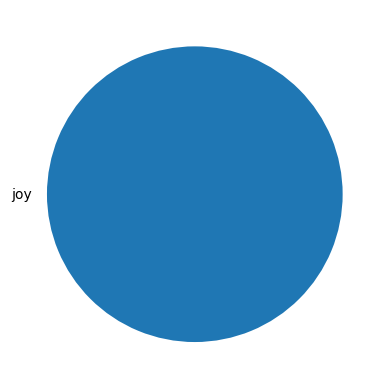

northern cardinal sentiment comparison


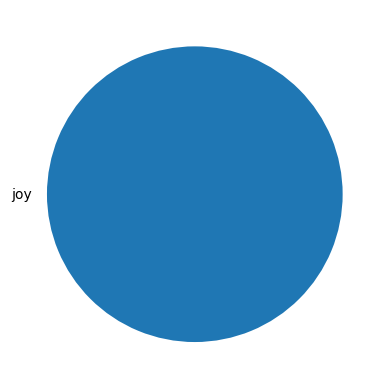

american goldfinch sentiment comparison


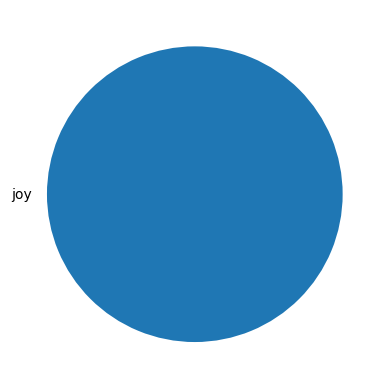

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import count,sum
# most paid attention species depends on comment

#spark.groupBy('sentiment').agg(count(col('sentiment'))).show()
#spark.select('id','title','label','comment_size').orderBy(desc('comment_size')).show()
#conclude the emotion which bird photo can give to human

# possible to distinguish which bird can bring what kind of emotion to humankinds
def index_to_specie(dic , index):
  return dic[index]
index_to_specie_udf = udf(index_to_specie, StringType())

print(index_to_specie(all_species,0)+' sentiment comparison')
x = spark_df.where(col('label')==0).groupBy('sentiment').agg(count('sentiment').alias('size')).orderBy(desc(col('size'))).where('sentiment is not null')
y = x.toPandas()['size'].tolist()
#y = x.where('sentiment is not null').rdd.map(lambda x: x['size']).collect()
mylabels = x.toPandas()['sentiment'].tolist()
#mylabels = x.where('sentiment is not null').rdd.map(lambda x: x['sentiment']).collect()
plt.pie(y, labels = mylabels)
plt.show()

print(index_to_specie(all_species,1)+' sentiment comparison')
x = spark_df.where(col('label')==1).groupBy('sentiment').agg(count('sentiment').alias('size')).orderBy(desc(col('size'))).where('sentiment is not null')

y = x.where('sentiment is not null').rdd.map(lambda x: x['size']).collect()
mylabels = x.toPandas()['sentiment'].tolist()
plt.pie(y, labels = mylabels)
plt.show()

print(index_to_specie(all_species,2)+' sentiment comparison')
x = spark_df.where(col('label')==2).groupBy('sentiment').agg(count('sentiment').alias('size')).orderBy(desc(col('size'))).where('sentiment is not null')

y = x.where('sentiment is not null').rdd.map(lambda x: x['size']).collect()
mylabels = x.toPandas()['sentiment'].tolist()
plt.pie(y, labels = mylabels)
plt.show()

#love , anger , fear , surprise


In [15]:
#owner_list = spark_df.select('owner').collect()
def preference(owners):
  lists = []
  for i in range(len(owners)):
    data = api.people.getPhotos(user_id=owners[i])['photos']['photo']
    rdd = spark.sparkContext.parallelize(data)
    top_foto = rdd.toDF()
    #change
    #data_pd = ps.DataFrame(data)
    #top_foto = data_pd.to_spark()
    top_foto = top_foto.groupBy('title').agg(count("title").alias("count")).orderBy(desc('count'))
    lists.append([top_foto.collect()[0]['title'],top_foto.collect()[1]['title'],top_foto.collect()[2]['title']])
    #top_foto.groupBy('title').agg(count("title").alias("count")).orderBy(desc('count')).collect()[1]['title']
  return lists


#change each bird , title comparison


#preference_list = spark_df.select('owner','label')




In [18]:
owner_list = spark_df.rdd.map(lambda x: x['owner']).collect()
data = preference(owner_list)
columns = ["id","prefer_topic3"]
dataframe = spark.createDataFrame(zip(owner_list, data), columns)
spark_df = spark_df.join(dataframe,spark_df["owner"] == dataframe["id"])



In [19]:
def top3fan(owner_ids):
  List = []
  for i in range(len(owner_ids)):
    data = api.people.getPhotos(user_id=owner_ids[i])['photos']['photo']
    #rdd = spark.sparkContext.parallelize(data)
    #top_foto = rdd.toDF()
    data_pd = ps.DataFrame(data)
    top_foto = data_pd.to_spark()
    #photos = top_foto.rdd.map(lambda x: x['id']).collect()
    photos = data_pd['id'].tolist()
    comments_list = []
    commenters_list = []
    #print(owner_ids[i])
    for i in range(len(photos)):
      if('comment' in (api.photos.comments.getList(photo_id = photos[i])['comments'])):
        data = api.photos.comments.getList(photo_id = photos[i])['comments']['comment']
        #print(data)
        #rdd = spark.sparkContext.parallelize(data)
        #comment = rdd.toDF()
        data_pd = ps.DataFrame(data)
        #comment = data_pd.to_spark()
        #comments = comment.rdd.map(lambda x: x['_content']).collect()
        comments = data_pd['_content'].tolist()
        #commenters = comment.rdd.map(lambda x: x['author']).collect()
        commenters = data_pd['author'].tolist()
        comments_list = comments_list + comments
        commenters_list = commenters_list +commenters
      else:
        comments = None
        commenters = None
    if((len(comments_list) != 0)&(len(commenters_list) != 0)):
      columns = ['author', 'comment']
      dataframe = spark.createDataFrame(zip(commenters_list, comments_list), columns)
      dataframe = dataframe.withColumn("sentiment", sentiment_udf(dataframe["comment"]))
      fan_ranking = dataframe.groupBy('author').agg(count("author").alias("count")).orderBy(desc('count'))
      #change
      fan_ranking = fan_ranking.toPandas()
      #print(fan_ranking['author'])
      if(len(fan_ranking) == 1):
        List.append([fan_ranking.iloc[0]['author']])
      elif(len(fan_ranking) == 2):
        List.append([fan_ranking.iloc[0]['author'],fan_ranking.iloc[1]['author']])
      else:
        List.append([fan_ranking.iloc[0]['author'],fan_ranking.iloc[1]['author'],fan_ranking.iloc[2]['author']])
  # fan of photographer
  return List

In [20]:
#data = top3fan(owner_list)
data = top3fan(owner_list)
columns = ["id","top3_fan"]
dataframe = spark.createDataFrame(zip(owner_list, data), columns)
spark_df = spark_df.join(dataframe,spark_df.owner == dataframe.id)
spark_df.show()

+-----------+-------------+--------------------+-----+--------------------+--------------------+---------+------------+---+-------------+--------------------+-------------+--------------------+
|         id|        owner|               title|label|            comments|             authors|sentiment|comment_size|top|           id|       prefer_topic3|           id|            top3_fan|
+-----------+-------------+--------------------+-----+--------------------+--------------------+---------+------------+---+-------------+--------------------+-------------+--------------------+
|52114903860|110466196@N07|  American Goldfinch|    2|[The perfect pose...|[40724294@N04, 60...|      joy|           4|  3|110466196@N07|[House finch, Ame...|110466196@N07|[40724294@N04, 15...|
|52114903860|110466196@N07|  American Goldfinch|    2|[The perfect pose...|[40724294@N04, 60...|      joy|           4|  3|110466196@N07|[House finch, Ame...|110466196@N07|[16159474@N00, 62...|
|52032894333|110466196@N07|  A

In [ ]:
spark_df.printSchema()

To find the photo size own by each author

In [21]:
# the default of api is to search 100 photos , for more photo size, there should be change of parameter
def photo_size(owner_id):
  data = api.people.getPhotos(user_id=owner_id)['photos']['photo']
  size = len(data)
  return size
photo_size_udf = udf(photo_size, StringType())
spark_df = spark_df.withColumn("photo_size", photo_size_udf(col("owner")))
spark_df.show()

+-----------+-------------+--------------------+-----+--------------------+--------------------+---------+------------+---+-------------+--------------------+-------------+--------------------+----------+
|         id|        owner|               title|label|            comments|             authors|sentiment|comment_size|top|           id|       prefer_topic3|           id|            top3_fan|photo_size|
+-----------+-------------+--------------------+-----+--------------------+--------------------+---------+------------+---+-------------+--------------------+-------------+--------------------+----------+
|52114903860|110466196@N07|  American Goldfinch|    2|[The perfect pose...|[40724294@N04, 60...|      joy|           4|  3|110466196@N07|[House finch, Ame...|110466196@N07|[40724294@N04, 15...|       100|
|52114903860|110466196@N07|  American Goldfinch|    2|[The perfect pose...|[40724294@N04, 60...|      joy|           4|  3|110466196@N07|[House finch, Ame...|110466196@N07|[1615947

My idea here is to create a empty df and insert information of spam

message to this df

criteria is when there is one emotion reach 80 % , others are spam

but it is not complete , i tried to join in the function , but it is not working

In [9]:
schema = StructType([
  StructField('shit_comment', StringType(), True),
  StructField('shit_author', StringType(), True),
  StructField('sentiment', StringType(), True),
  StructField('id', StringType(), True),
  ])
spams = spark.createDataFrame([], schema)

spams.show()

+------------+-----------+---------+---+
|shit_comment|shit_author|sentiment| id|
+------------+-----------+---------+---+
+------------+-----------+---------+---+



In [11]:
from pyspark.sql.functions import count,sum

def shit_comment_emotioin(comment):
  def remove_html(comment):
    #NLP preprocessing
    CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(CLEANR, '', comment)
    cleantext = cleantext.replace('\n',' ')
    return cleantext[:512]
  classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)
  x = remove_html(comment)
  prediction = classifier(x)
  Max = 0
  label = None
  for i in range(len(prediction[0])):
          if(prediction[0][i]['score'] > Max):
            Max = prediction[0][i]['score']
            label =  prediction[0][i]['label']
  return label
shit_comment_emotioin_udf = udf(shit_comment_emotioin, StringType())


def spam_capturer(id):
  if('comment' in (api.photos.comments.getList(photo_id = id)['comments'])):
    data = api.photos.comments.getList(photo_id = id)['comments']['comment']
    rdd = spark.sparkContext.parallelize(data)
    comment = rdd.toDF()
    comments = comment.rdd.map(lambda x: x['_content']).collect()
    commenters = comment.rdd.map(lambda x: x['author']).collect()
    columns = ['author', 'comment']
    dataframe = spark.createDataFrame(zip(commenters, comments), columns)
    dataframe = dataframe.withColumn("sentiment", shit_comment_emotioin_udf(col("comment")))
    emo = dataframe.groupBy('sentiment').agg(count("sentiment").alias("count")).orderBy(desc('count')).collect()[0]['sentiment']
    unique_count = dataframe.count()
    if(((dataframe.where(col('sentiment')==emo).count() / unique_count) >= 0.8) & ((dataframe.where(col('sentiment')==emo).count() / unique_count) < 1)):
      columns = ['shit_comment', 'shit_author','sentiment','id']
      shit = dataframe.where(col('sentiment')!=emo)
      shit_comment = shit.rdd.map(lambda x: x['comment']).collect()
      shit_author = shit.rdd.map(lambda x: x['author']).collect()
      sentiment = shit.rdd.map(lambda x: x['sentiment']).collect()
      id = [id]*shit.count()
      #print(zip(shit_comment, shit_author,sentiment,id))
      shit_df = spark.createDataFrame(zip(shit_comment, shit_author,sentiment,id), columns)
      shit_df.show()


#change
#owner = spark.rdd.map(lambda x: x['id']).collect()
spam_capturer(22847153945)


+--------------------+-------------+---------+-----------+
|        shit_comment|  shit_author|sentiment|         id|
+--------------------+-------------+---------+-----------+
|Lovely colours in...|118948217@N06|     love|22847153945|
|Lovely bluejay ca...| 46353871@N00|     love|22847153945|
|            Cracker!|  9750464@N02|    anger|22847153945|
|I love these bird...| 55032983@N07|     love|22847153945|
|Lovely shot of a ...|124011531@N04|     love|22847153945|
|...beautiful imag...| 38741307@N07|     love|22847153945|
|  Lovely ....nice BG|  7522188@N02|     love|22847153945|
|I wish they would...|127727047@N05|  sadness|22847153945|
|                Nice| 33856622@N07|    anger|22847153945|
|  Magnifique capture|125881398@N07|    anger|22847153945|
|       Muito lindo..| 65548569@N07|    anger|22847153945|
|         Mooi hoor!!| 99745284@N00|    anger|22847153945|
|Amazing capture S...| 75715068@N02| surprise|22847153945|
|<img src="https:/...| 45762667@N08|    anger|2284715394

here , i am going to use top3_fan to find possible friends pairs ,
but it is not complete

In [ ]:
# more api on the way
def possible_friend():
  friends = spark_df.select('owner','top3_fan').distinct
  for i in range(len(friends.count())):
    fans = friends.rdd.map(lambda x: x['top3_fan']).collect()
    for fan in fans:
      if()
  return
